## Como fazer um backtest?

In [3]:
# https://github.com/StreamAlpha/tvdatafeed
from tvDatafeed import TvDatafeed, Interval
from datetime import datetime, timedelta
import pandas as pd

username = 'rodrigo.tadewald'
password = open('pass', 'r').read()

tv = TvDatafeed(username, password)

In [4]:
tv.search_symbol('PETR4','BMFBOVESPA')

[{'symbol': 'PETR4',
  'description': 'PETROBRAS PN N2',
  'type': 'stock',
  'exchange': 'BMFBOVESPA',
  'currency_code': 'BRL',
  'logoid': 'brasileiro-petrobras',
  'provider_id': 'ice',
  'country': 'BR',
  'typespecs': ['preferred']},
 {'symbol': 'PETRP',
  'description': 'FUTURE OF PETR4',
  'type': 'futures',
  'exchange': 'BMFBOVESPA',
  'currency_code': 'BRL',
  'logoid': 'brasileiro-petrobras',
  'provider_id': 'ice',
  'country': 'BR',
  'contracts': [{'symbol': 'PETRP1!',
    'typespecs': ['continuous', 'synthetic'],
    'description': 'CONTINUOUS: CURRENT CONTRACT IN FRONT'},
   {'symbol': 'PETRP2!',
    'typespecs': ['continuous', 'synthetic'],
    'description': 'CONTINUOUS: NEXT CONTRACT IN FRONT'},
   {'symbol': 'PETRPX2022', 'description': 'NOV 2022'},
   {'symbol': 'PETRPZ2022', 'description': 'DEC 2022'},
   {'symbol': 'PETRPF2023', 'description': 'JAN 2023'}]},
 {'symbol': 'PETR4F',
  'description': 'PETROBRAS PN N2',
  'type': 'stock',
  'exchange': 'BMFBOVESPA',


In [5]:
df = tv.get_hist(symbol='PETR4',exchange='BMFBOVESPA',interval=Interval.in_5_minute, n_bars= 5000)

In [66]:
df = pd.read_csv("petr4.csv")
df.set_index("datetime", inplace=True)

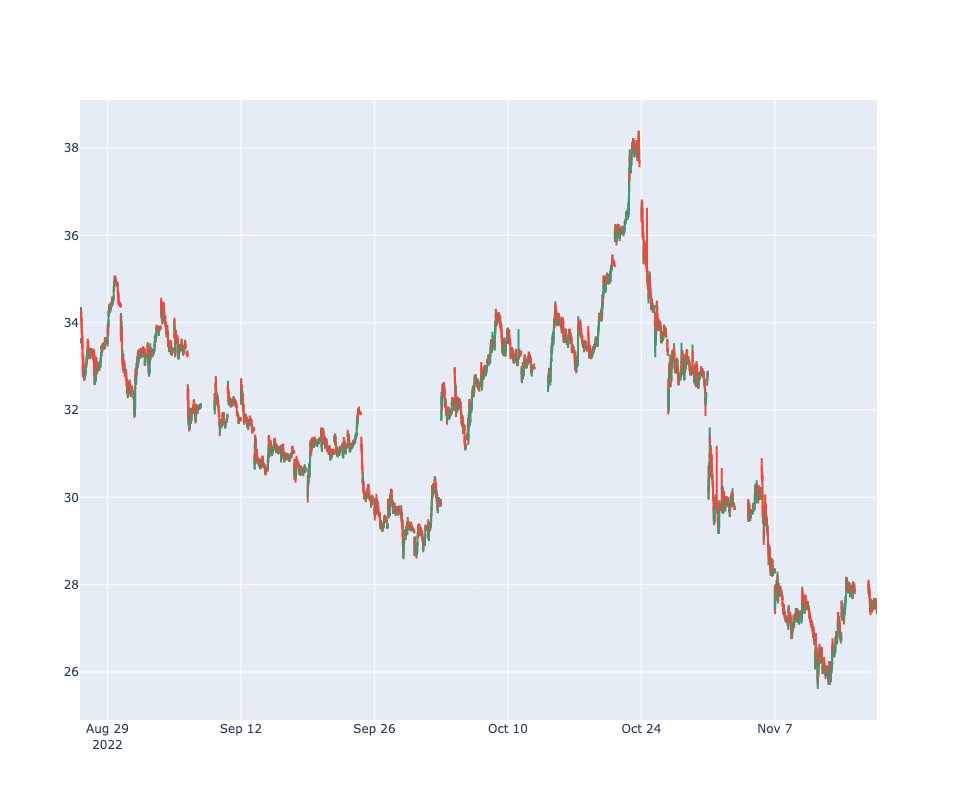

In [68]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.update_xaxes(rangebreaks=[
        dict(bounds=[18, 10], pattern="hour"), #hide hours outside of 9am-5pm
        dict(bounds=["sat", "mon"]), #hide weekends
    ])
fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

### Cálculo do RSI

https://www.macroption.com/rsi-calculation/

In [10]:
periods = 21
close_delta = df["close"] / df["close"].shift(1) - 1

up = close_delta.clip(lower=0)
down = -1 * close_delta.clip(upper=0)

ma_up = up.rolling(window = periods).mean()
ma_down = down.rolling(window = periods).mean()

rsi = ma_up / ma_down
df["rsi"] = 100 - (100/(1 + rsi))

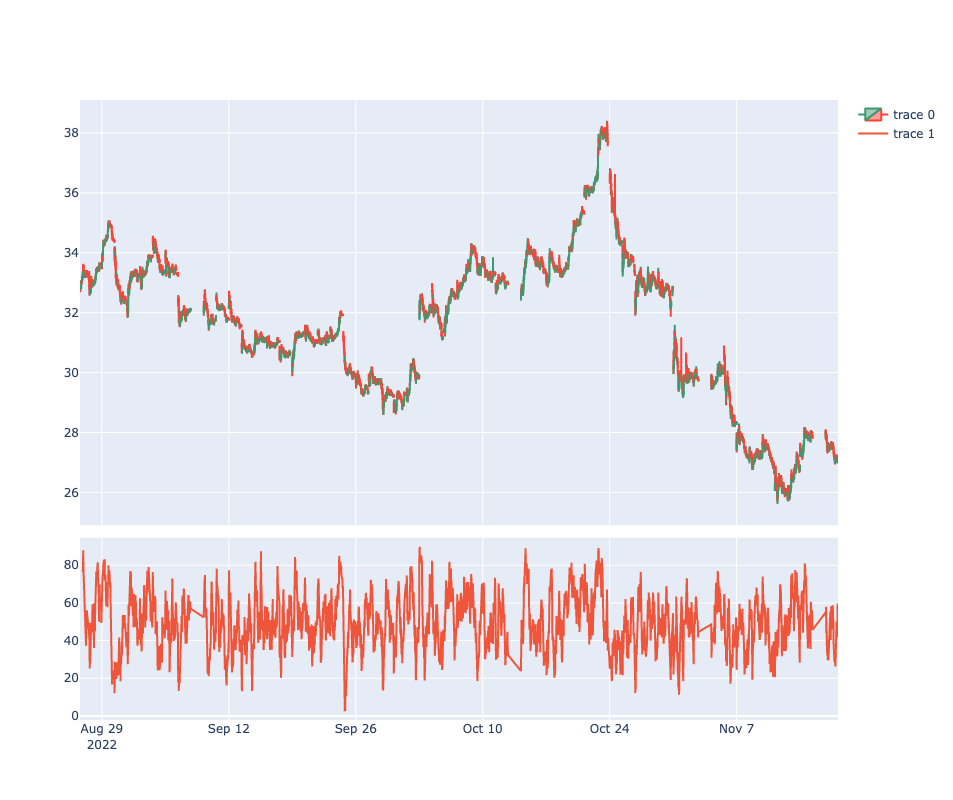

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, row_heights=[0.7, 0.3], vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close']), row=1, col=1)

fig.add_trace(go.Line(x=df.index,
                y=df['rsi']), row=2, col=1)

fig.update_xaxes(rangebreaks=[
        dict(bounds=[18, 10], pattern="hour"), #hide hours outside of 9am-5pm
        dict(bounds=["sat", "mon"]), #hide weekends
    ])
fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

### Backtestando

Lembrem-se: Um backtest deve ser encarado como uma função que recebe parâmetros (da estratégia, janela temporal, custos, slippage) e devolve trades executados.

In [227]:
def get_rsi(window):
    # Cálculo do RSI
    close_delta = df["close"] / df["close"].shift(1) - 1

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.rolling(window = window).mean()
    ma_down = down.rolling(window = window).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [125]:
# Parâmetros
window = 14
up_exit = 70
down_entry = 30
bet_size = 100


# Estratégia
df["rsi"] = get_rsi(window)
dict_trades = []
t = 0
for idx, row in df.iterrows():
    if row['rsi'] <= down_entry and t == 0:
        dict_trades += [{'price': row['close'], 'time': idx, 'kind': 'buy', 'quantity': bet_size}]
        t = 1
    
    elif row['rsi'] > up_exit and t == 1:
        dict_trades += [{'price': row['close'], 'time': idx, 'kind': 'sell', 'quantity': -bet_size}]
        t = 0

df_trades_raw = pd.DataFrame(dict_trades).set_index('time')
df_buys = df_trades_raw[df_trades_raw['kind'] == 'buy']
df_sells = df_trades_raw[df_trades_raw['kind'] == 'sell']

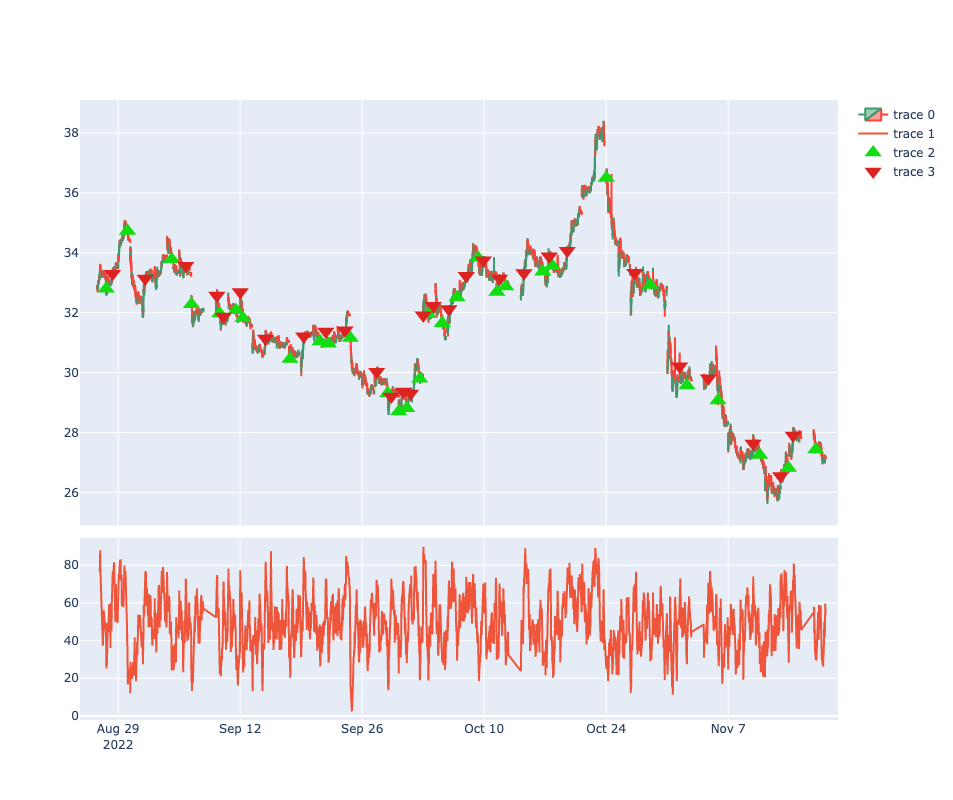

In [78]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, row_heights=[0.7, 0.3], vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close']), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index,
                y=df['rsi']), row=2, col=1)

fig.add_trace(go.Scatter(x=df_buys.index,y=df_buys['price'], marker_color='#11dd11',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-up'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_sells.index,y=df_sells['price'], marker_color='#dd2222',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-down'), row=1, col=1)

fig.update_xaxes(rangebreaks=[
        dict(bounds=[18, 10], pattern="hour"), #hide hours outside of 9am-5pm
        dict(bounds=["sat", "mon"]), #hide weekends
    ])
fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

### Marcação a mercado

In [126]:
df_trades = df_trades_raw.join(df["close"], how='outer')

df_trades["position"] = df_trades["quantity"].shift(1).fillna(0).cumsum()

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, row_heights=[0.6, 0.2, 0.2], vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close']), row=1, col=1)

fig.add_trace(go.Scatter(x=df_buys.index,y=df_buys['price'], marker_color='#11dd11',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-up'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_sells.index,y=df_sells['price'], marker_color='#dd2222',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-down'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index,
                y=df_trades['position']), row=2, col=1)


fig.add_trace(go.Scatter(x=df.index,
                y=df['rsi']), row=3, col=1)


fig.update_xaxes(rangebreaks=[
        dict(bounds=[18, 10], pattern="hour"), #hide hours outside of 9am-5pm
        dict(bounds=["sat", "mon"]), #hide weekends
    ])
fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

NameError: name 'df' is not defined

In [128]:
df_trades_raw.head(2)

price  kind  quantity
time                                      
2022-08-26 10:10:00   32.8   buy       100
2022-08-26 14:20:00   33.3  sell      -100

In [149]:
df_trades["ret_market"] = df_trades["close"] - df_trades["close"].shift(1)
df_trades["ret"] = df_trades["ret_market"] * df_trades["position"]
df_trades["ret_cum"] = df_trades["ret"].cumsum()

In [150]:
df_trades[(df_trades["position"] == 0) & (df_trades["position"].shift(1) > 0)]

price kind  quantity  close  position  ret_market  ret  \
2022-08-26 14:25:00    NaN  NaN       NaN  33.40       0.0        0.10  0.0   
2022-08-31 11:50:00    NaN  NaN       NaN  33.15       0.0        0.01  0.0   
2022-09-05 14:30:00    NaN  NaN       NaN  33.52       0.0       -0.05 -0.0   
2022-09-08 10:50:00    NaN  NaN       NaN  32.53       0.0       -0.04 -0.0   
2022-09-08 15:10:00    NaN  NaN       NaN  31.89       0.0        0.02  0.0   
2022-09-12 10:10:00    NaN  NaN       NaN  32.42       0.0       -0.27 -0.0   
2022-09-14 10:40:00    NaN  NaN       NaN  31.36       0.0        0.22  0.0   
2022-09-19 11:50:00    NaN  NaN       NaN  31.16       0.0       -0.05 -0.0   
2022-09-21 10:15:00    NaN  NaN       NaN  31.39       0.0        0.02  0.0   
2022-09-22 14:50:00    NaN  NaN       NaN  31.44       0.0        0.03  0.0   
2022-09-27 11:35:00    NaN  NaN       NaN  29.98       0.0       -0.05 -0.0   
2022-09-28 13:10:00    NaN  NaN       NaN  29.31       0.0        0.11  0.0   
2022-09-29 12:50:00    NaN  NaN       NaN  29.32       0.0       -0.05 -0.0   
2022-09-29 17:50:00    NaN  NaN       NaN  29.30       0.0        0.00  0.0   
2022-10-03 10:10:00    NaN  NaN       NaN  32.21       0.0        0.30  0.0   
2022-10-03 16:45:00    NaN  NaN       NaN  32.22       0.0       -0.01 -0.0   
2022-10-05 10:55:00    NaN  NaN       NaN  32.07       0.0       -0.05 -0.0   
2022-10-06 14:20:00    NaN  NaN       NaN  33.15       0.0       -0.08 -0.0   
2022-10-07 17:35:00    NaN  NaN       NaN  33.77       0.0        0.02  0.0   
2022-10-11 12:10:00    NaN  NaN       NaN  33.12       0.0       -0.02 -0.0   
2022-10-13 12:10:00    NaN  NaN       NaN  33.45       0.0        0.13  0.0   
2022-10-17 12:45:00    NaN  NaN       NaN  33.84       0.0       -0.04 -0.0   
2022-10-18 16:35:00    NaN  NaN       NaN  34.17       0.0        0.10  0.0   
2022-10-26 12:50:00    NaN  NaN       NaN  33.19       0.0       -0.14 -0.0   
2022-11-01 10:15:00    NaN  NaN       NaN  29.90       0.0       -0.31 -0.0   
2022-11-03 13:05:00    NaN  NaN       NaN  29.77       0.0       -0.04 -0.0   
2022-11-09 10:25:00    NaN  NaN       NaN  27.87       0.0        0.24  0.0   
2022-11-11 12:25:00    NaN  NaN       NaN  26.59       0.0        0.04  0.0   
2022-11-14 12:40:00    NaN  NaN       NaN  27.89       0.0       -0.01 -0.0   

                     ret_cum  
2022-08-26 14:25:00     50.0  
2022-08-31 11:50:00   -109.0  
2022-09-05 14:30:00   -130.0  
2022-09-08 10:50:00   -101.0  
2022-09-08 15:10:00   -111.0  
2022-09-12 10:10:00    -50.0  
2022-09-14 10:40:00   -118.0  
2022-09-19 11:50:00    -42.0  
2022-09-21 10:15:00     -9.0  
2022-09-22 14:50:00     36.0  
2022-09-27 11:35:00    -76.0  
2022-09-28 13:10:00    -87.0  
2022-09-29 12:50:00    -20.0  
2022-09-29 17:50:00     29.0  
2022-10-03 10:10:00    241.0  
2022-10-03 16:45:00    269.0  
2022-10-05 10:55:00    316.0  
2022-10-06 14:20:00    388.0  
2022-10-07 17:35:00    380.0  
2022-10-11 12:10:00    425.0  
2022-10-13 12:10:00    470.0  
2022-10-17 12:45:00    521.0  
2022-10-18 16:35:00    571.0  
2022-10-26 12:50:00    254.0  
2022-11-01 10:15:00    -17.0  
2022-11-03 13:05:00      7.0  
2022-11-09 10:25:00   -137.0  
2022-11-11 12:25:00   -207.0  
2022-11-14 12:40:00    -98.0

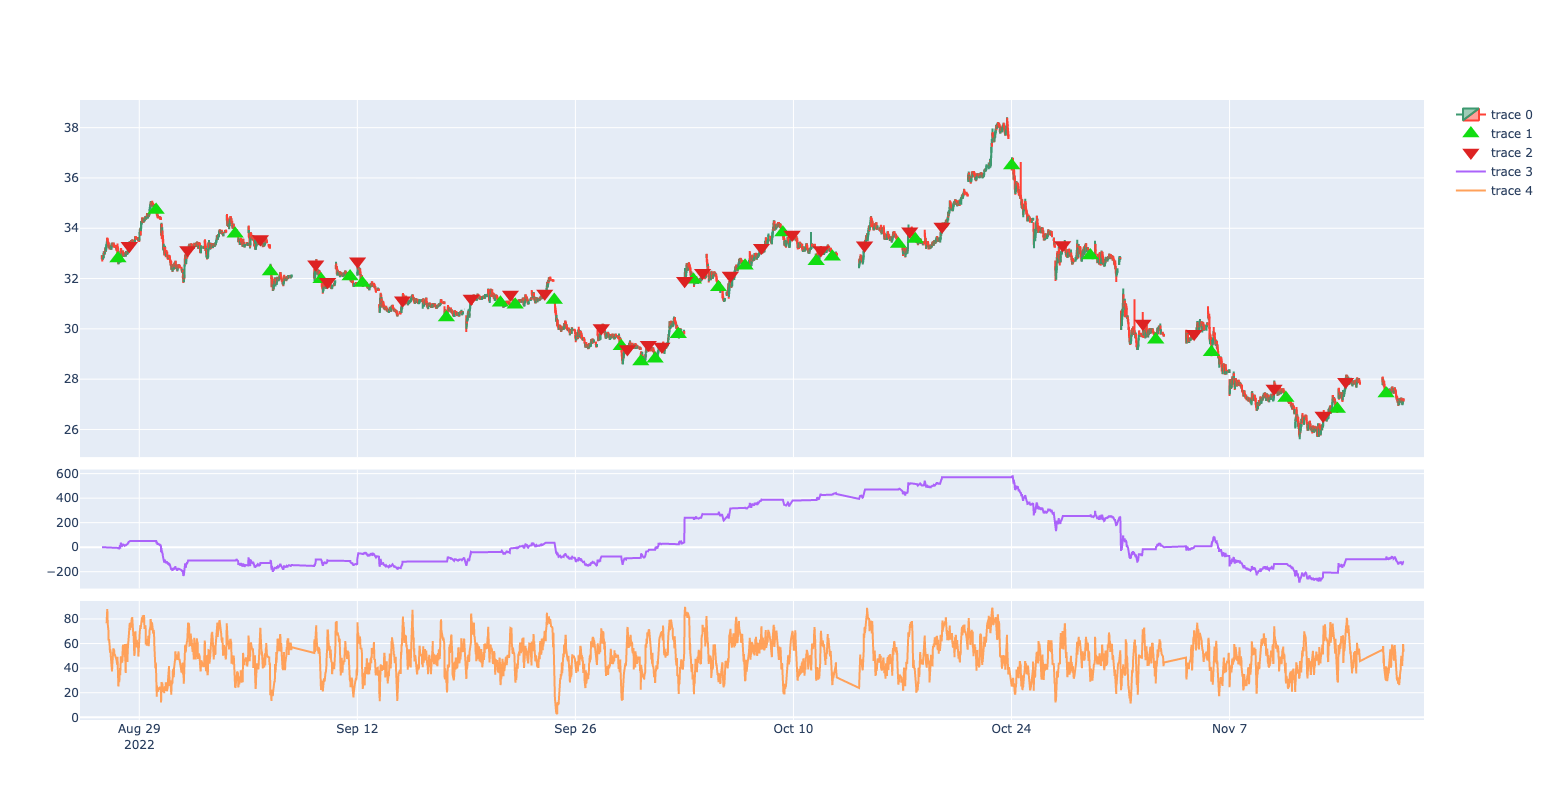

In [152]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, row_heights=[0.6, 0.2, 0.2], vertical_spacing=0.02, shared_xaxes=True)

fig.add_trace(go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close']), row=1, col=1)

fig.add_trace(go.Scatter(x=df_buys.index,y=df_buys['price'], marker_color='#11dd11',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-up'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_sells.index,y=df_sells['price'], marker_color='#dd2222',  marker_size=15,
                 mode="markers", marker_symbol= 'triangle-down'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index,
                y=df_trades['ret_cum']), row=2, col=1)


fig.add_trace(go.Scatter(x=df.index,
                y=df['rsi']), row=3, col=1)



fig.update_xaxes(rangebreaks=[
        dict(bounds=[18, 10], pattern="hour"), #hide hours outside of 9am-5pm
        dict(bounds=["sat", "mon"]), #hide weekends
    ])
fig.update_layout(xaxis_rangeslider_visible=False, height=800)
fig.show()

## Mensuração de performance

In [160]:
df_buys.shape

(30, 3)

<AxesSubplot: >

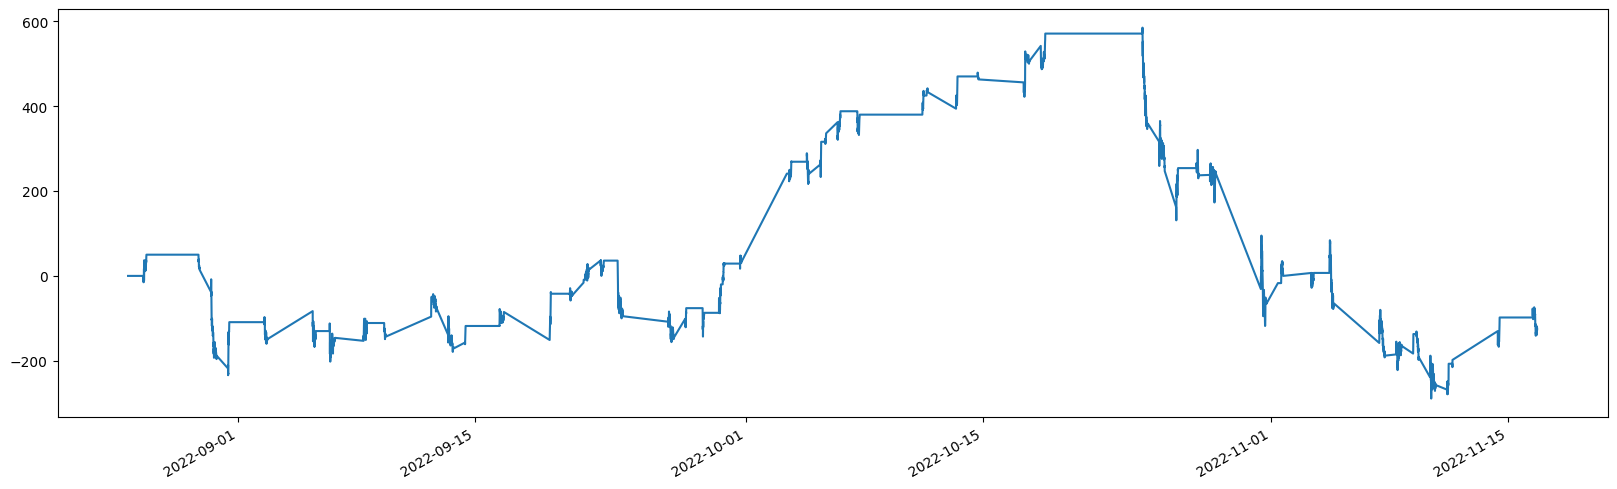

In [163]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 6))
df_trades["ret_cum"].plot()

### Drawdown

In [177]:
initial_capital = 5000
df_trades["ret_cum"] = initial_capital + df_trades["ret"].cumsum()

In [178]:
df_trades["max_cum"] = df_trades["ret_cum"].cummax()
df_trades["drawdown"] = df_trades["ret_cum"] / df_trades["max_cum"] - 1

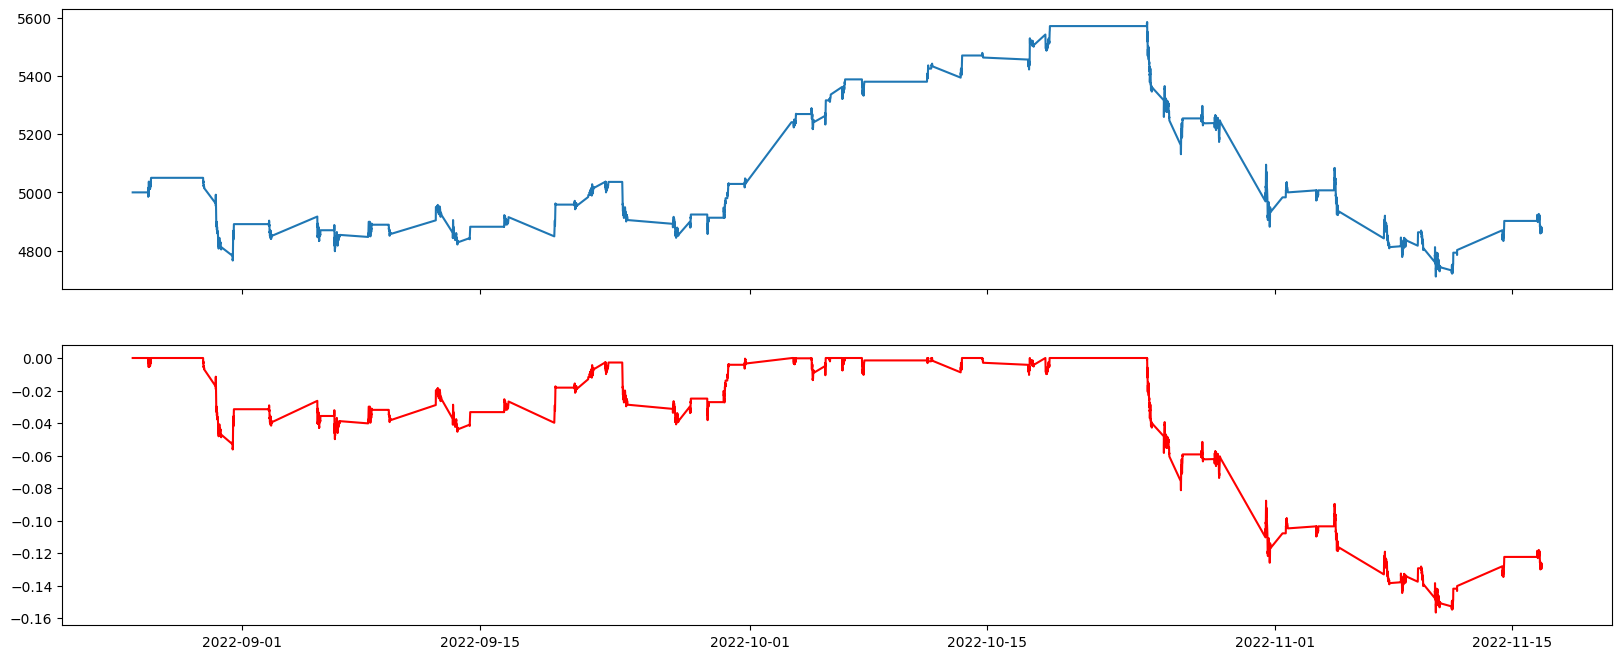

In [180]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

ax[0].plot(df_trades["ret_cum"])
ax[1].plot(df_trades["drawdown"], color="red")

### Underwater period

In [184]:
initial_capital = 5000
df_trades["ret_cum"] = initial_capital + df_trades["ret"].cumsum()

df_trades["max_cum"] = df_trades["ret_cum"].cummax()
df_trades['underwater'] = df_trades['ret_cum'] < df_trades['max_cum']

14.368055555555555


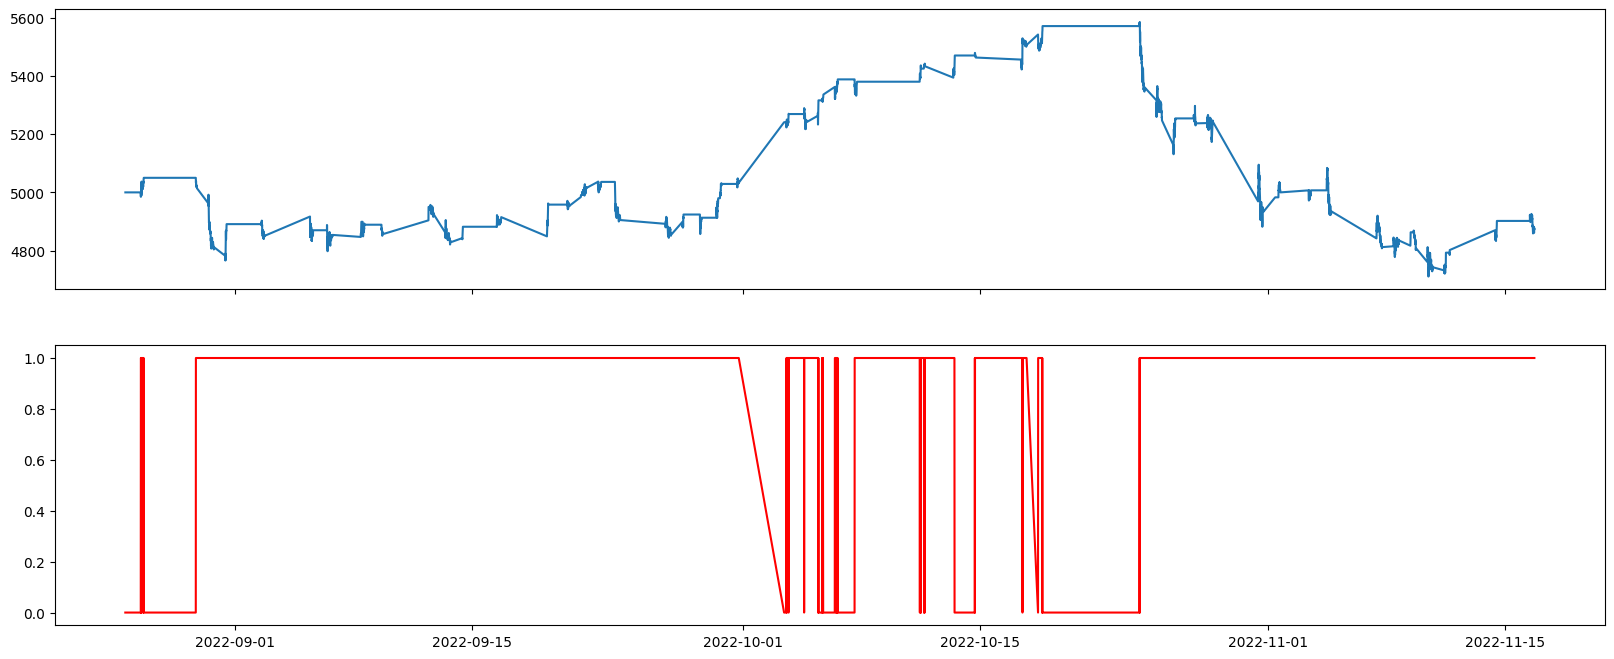

In [190]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 8))

ax[0].plot(df_trades["ret_cum"])
ax[1].plot(df_trades["underwater"], color="red")

print(df_trades["underwater"].sum() * 5 / 60 / 24)

### Índice Sharpe

In [198]:
df_trades["ret"].groupby(df_trades.index.date).sum().mean() / df_trades["ret"].groupby(df_trades.index.date).sum().std() * (252 ** 0.5)

-0.4226171935252999

## Otimização de parâmetros

### Método de varredura

In [225]:
def get_rsi(window):
    # Cálculo do RSI
    close_delta = df["close"] / df["close"].shift(1) - 1

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.rolling(window = window).mean()
    ma_down = down.rolling(window = window).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [228]:
# Parâmetros
bet_size = 100
dict_varr = []

for window in [14, 21]:
    for up_exit in [60, 70, 80]:
        for down_entry in [20, 30, 40]:
            df["rsi"] = get_rsi(window)
            dict_trades = []
            t = 0
            for idx, row in df.iterrows():
                if row['rsi'] <= down_entry and t == 0:
                    dict_trades += [{'price': row['close'], 'time': idx, 'kind': 'buy', 'quantity': bet_size}]
                    t = 1

                elif row['rsi'] > up_exit and t == 1:
                    dict_trades += [{'price': row['close'], 'time': idx, 'kind': 'sell', 'quantity': -bet_size}]
                    t = 0
            
            # Mensuração de estratégias
            df_trades_raw = pd.DataFrame(dict_trades).set_index('time')
            df_trades = df_trades_raw.join(df["close"], how='outer')
            df_trades["position"] = df_trades["quantity"].shift(1).fillna(0).cumsum()
            df_trades["ret_market"] = df_trades["close"] - df_trades["close"].shift(1)
            df_trades["ret"] = df_trades["ret_market"] * df_trades["position"]
            df_trades["ret_cum"] = df_trades["ret"].cumsum()
            
            sharpe = df_trades["ret"].groupby(df_trades.index.date).sum().mean() / df_trades["ret"].groupby(df_trades.index.date).sum().std() * (252 ** 0.5)
            print(f"Window: {window}, up_exit: {up_exit}, down_entry: {down_entry} -> sharpe: {sharpe}")
            dict_varr += [{'window': window, 'up_exit': up_exit, 'down_entry': down_entry, 'sharpe': sharpe}]
            

Window: 14, up_exit: 60, down_entry: 20 -> sharpe: 0.07949911596442157
Window: 14, up_exit: 60, down_entry: 30 -> sharpe: -2.996481154451559
Window: 14, up_exit: 60, down_entry: 40 -> sharpe: -2.2261322670122476
Window: 14, up_exit: 70, down_entry: 20 -> sharpe: 0.15339783580977887
Window: 14, up_exit: 70, down_entry: 30 -> sharpe: -1.5827625890688342
Window: 14, up_exit: 70, down_entry: 40 -> sharpe: -1.647520178830496
Window: 14, up_exit: 80, down_entry: 20 -> sharpe: -1.9774639956743463
Window: 14, up_exit: 80, down_entry: 30 -> sharpe: -3.0806409073035823
Window: 14, up_exit: 80, down_entry: 40 -> sharpe: -2.883902880226678
Window: 21, up_exit: 60, down_entry: 20 -> sharpe: -0.9686524152955555
Window: 21, up_exit: 60, down_entry: 30 -> sharpe: -0.3871953321684051
Window: 21, up_exit: 60, down_entry: 40 -> sharpe: -1.275637932863908
Window: 21, up_exit: 70, down_entry: 20 -> sharpe: -1.4187680572839574
Window: 21, up_exit: 70, down_entry: 30 -> sharpe: -0.4226171935252999
Window: 21

In [229]:
df_varr = pd.DataFrame(dict_varr)

<AxesSubplot: xlabel='up_exit', ylabel='window'>

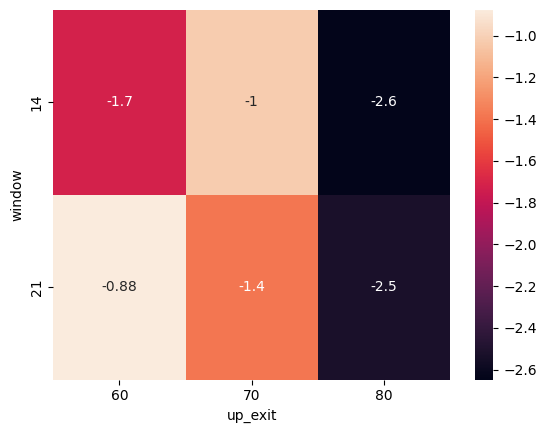

In [230]:
import seaborn as sns
sns.heatmap(df_varr.pivot_table(index="window", columns="up_exit", values="sharpe"), annot=True)